In [1]:
from google.colab import drive
drive.mount('/content/drive')

DATA_PATH = "/content/drive/MyDrive/datathon/data/"

SEED = 42

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import torch
from tqdm.auto import tqdm
import random
import os




def reset_seeds(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [ ]:
train_tr = pd.read_csv(f"/content/drive/MyDrive/datathon/data/teams_train.csv") # 학습용 승부예측 데이터
train_target = pd.read_csv(f"/content/drive/MyDrive/datathon/data/teams_train_target.csv") # 학습용 정답 데이터
test_tr = pd.read_csv(f"/content/drive/MyDrive/datathon/data/teams_test.csv") # 테스트용 승부예측 데이터
test_target = pd.read_csv(f"/content/drive/MyDrive/datathon/data/teams_test_target.csv") # 테스트용 정답 데이터

In [ ]:
train_tr.shape, test_tr.shape

((9913, 111), (2324, 111))

In [ ]:
drop_list_team = [
    "participantid",
    "playername",
    'position',
    "champion",
    "teamkills",
    "teamdeaths",
    "firstbloodkill",
    "firstbloodassist",
    "firstbloodvictim",
    "dragons (type unknown)",
    "damageshare",
    "earnedgoldshare",
    "total cs",
    "monsterkillsownjungle",
    "monsterkillsenemyjungle",
    "goldat20",
    "xpat20",
    "csat20",
    "opp_goldat20",
    "opp_xpat20",
    "opp_csat20",
    "golddiffat20",
    "xpdiffat20",
    "csdiffat20",
    "killsat20",
    "assistsat20",
    "deathsat20",
    "opp_killsat20",
    "opp_assistsat20",
    "opp_deathsat20",
    "goldat25",
    "xpat25",
    "csat25",
    "opp_goldat25",
    "opp_xpat25",
    "opp_csat25",
    "golddiffat25",
    "xpdiffat25",
    "csdiffat25",
    "killsat25",
    "assistsat25",
    "deathsat25",
    "opp_killsat25",
    "opp_assistsat25",
    "opp_deathsat25"
]

In [ ]:
train_ft=train_tr
test_ft=test_tr

In [ ]:
lpl_team = [
    "Anyone's Legend",
    "Bilibili Gaming",
    "EDward Gaming",
    "FunPlus Phoenix",
    "Invictus Gaming",
    "JD Gaming",
    "LGD Gaming",
    "LNG Esports",
    "Oh My God",
    "Rare Atom",
    "Royal Never Give Up",
    "Team WE",
    "Top Esports",
    "ThunderTalk Gaming",
    "Ultra Prime",
    "Weibo Gaming",
    "Ninjas in Pyjamas"
]

In [ ]:
missing_columns = train_ft.columns[train_ft.isnull().sum() > 0]
null_samples = train_ft[train_ft[missing_columns].isnull().any(axis=1)]

for idx, row in null_samples.iterrows():
    team_history = train_ft[
        (train_ft["teamname"] == row["teamname"])
        & (train_ft["gameid"] < row["gameid"])
    ].sort_values("gameid", ascending=False)

    for col in missing_columns:
        if pd.isnull(row[col]):
            if row["teamname"] in lpl_team:
                # LPL 팀인 경우 LCK 평균으로 채움
                lck_mean = train_ft[train_ft["league"] == "LCK"][col].mean()
                train_ft.loc[idx, col] = lck_mean
            else:
                # LPL 팀이 아닌 경우 해당 팀의 이전 5경기 평균으로 채움
                prev_5_mean = team_history[col].head(5).mean()
                if pd.notnull(prev_5_mean):
                    train_ft.loc[idx, col] = prev_5_mean
                else:
                    # 이전 5경기 데이터가 없는 경우 해당 팀의 전체 평균으로 채움
                    team_mean = train_ft[train_ft["teamname"] == row["teamname"]][col].mean()
                    train_ft.loc[idx, col] = team_mean

In [ ]:
train_ft.isnull().sum().sum()

0

In [ ]:
train_ft.shape, test_ft.shape

((9913, 111), (2324, 111))

In [ ]:
missing_columns = test_ft.columns[test_ft.isnull().sum() > 0]
missing_columns

Index([], dtype='object')

In [ ]:
#연도
# train_ft 처리
train_ft['year'] = pd.to_datetime(train_ft['date']).dt.year

# test_ft 처리
test_ft['year'] = pd.to_datetime(test_ft['date']).dt.year


In [ ]:
# 유효한 픽 데이터를 포함하는 행만 필터링
valid_pick_rows_train_ft = train_ft.dropna(subset=['pick1', 'pick2', 'pick3', 'pick4', 'pick5'], how='all')
valid_pick_rows_test_ft = test_ft.dropna(subset=['pick1', 'pick2', 'pick3', 'pick4', 'pick5'], how='all')

# 필터링된 train_ft 데이터에서 밴 및 픽 데이터를 하나의 열로 변환
champion_data_filtered_train_ft = valid_pick_rows_train_ft.melt(
    id_vars=['patch'],  # 패치 정보를 유지
    value_vars=['ban1', 'ban2', 'ban3', 'ban4', 'ban5', 'pick1', 'pick2', 'pick3', 'pick4', 'pick5'],
    var_name='type',  # 데이터 유형을 나타내는 열 이름 (ban/pick)
    value_name='champion'  # 챔피언 이름을 저장할 열 이름
)

# 변환된 train_ft 데이터에서 NaN(결측값) 제거
champion_data_filtered_train_ft = champion_data_filtered_train_ft.dropna(subset=['champion'])

# train_ft 데이터에서 패치와 챔피언별로 그룹화하여 선택 횟수 계산
champion_counts_filtered_train_ft = champion_data_filtered_train_ft.groupby(['patch', 'champion']).size().reset_index(name='count')

# train_ft 데이터에서 패치별로 챔피언 선택 횟수 기준으로 정렬
top_champions_by_patch_filtered_train_ft = champion_counts_filtered_train_ft.sort_values(['patch', 'count'], ascending=[True, False])

# 결과 표시
display(top_champions_by_patch_filtered_train_ft)


,patch,champion,count
79,12.01,Twisted Fate,108
9,12.01,Caitlyn,106
90,12.01,Xin Zhao,98
60,12.01,Renekton,86
11,12.01,Corki,85
...,...,...,...
3223,14.05,Rammus,1
3232,14.05,Shaco,1
3240,14.05,Taric,1
3249,14.05,Vex,1


In [ ]:
# Train 데이터 병합
# 챔피언별 선택 횟수를 train_ft에 병합
train_ft = train_ft.merge(
    top_champions_by_patch_filtered_train_ft,
    how='left',  # 패치와 챔피언에 대해 일치하는 경우 병합
    left_on=['patch', 'pick1'],  # train_ft에서 병합 기준 열
    right_on=['patch', 'champion']  # top_champions_by_patch_filtered_train_ft에서 병합 기준 열
)

# 'count' 열 이름 변경 (선택 횟수를 의미하는 더 명확한 이름으로)
train_ft.rename(columns={'count': 'pick1_count'}, inplace=True)

# Test 데이터 병합
valid_pick_rows_test_ft = test_ft.dropna(subset=['pick1', 'pick2', 'pick3', 'pick4', 'pick5'], how='all')

champion_data_filtered_test_ft = valid_pick_rows_test_ft.melt(
    id_vars=['patch'],  # 패치 정보를 유지
    value_vars=['ban1', 'ban2', 'ban3', 'ban4', 'ban5', 'pick1', 'pick2', 'pick3', 'pick4', 'pick5'],
    var_name='type',
    value_name='champion'
)

champion_data_filtered_test_ft = champion_data_filtered_test_ft.dropna(subset=['champion'])
champion_counts_filtered_test_ft = champion_data_filtered_test_ft.groupby(['patch', 'champion']).size().reset_index(name='count')
top_champions_by_patch_filtered_test_ft = champion_counts_filtered_test_ft.sort_values(['patch', 'count'], ascending=[True, False])

# Test 데이터 병합
test_ft = test_ft.merge(
    top_champions_by_patch_filtered_test_ft,
    how='left',
    left_on=['patch', 'pick1'],
    right_on=['patch', 'champion']
)

# 'count' 열 이름 변경 (선택 횟수를 의미하는 더 명확한 이름으로)
test_ft.rename(columns={'count': 'pick1_count'}, inplace=True)


In [ ]:
train_ft.shape, test_ft.shape

((9913, 114), (2324, 114))

In [ ]:
# CSV 파일로 저장
train_csv_path = '/content/drive/My Drive/train_ft_1차_.csv'
test_csv_path = '/content/drive/My Drive/test_ft_1차_.csv'

train_ft.to_csv(train_csv_path, index=False, encoding='utf-8-sig')  # UTF-8로 저장
test_ft.to_csv(test_csv_path, index=False, encoding='utf-8-sig')  # UTF-8로 저장

In [5]:
# 데이터 파일 불러오기
train_file_path = '/content/drive/My Drive/train_ft_1차_.csv'
test_file_path = '/content/drive/My Drive/test_ft_1차_.csv'

경기시간

In [6]:
# CSV 파일 불러오기
train_data_part1 = pd.read_csv(train_file_path)
train_data_part2 = pd.read_csv(test_file_path)

# 두 데이터를 합쳐 하나의 train_data로 사용
train_data = pd.concat([train_data_part1, train_data_part2], ignore_index=True)

# 결과 확인
train_data_shape = train_data.shape
train_data_preview = train_data.head()

train_data_shape, train_data_preview


((12237, 114),
                   gameid league   split  playoffs              date  game  \
 0  ESPORTSTMNT01_2700815    LCK  Spring         0   2022-01-12 6:20     1   
 1  ESPORTSTMNT01_2700815    LCK  Spring         0   2022-01-12 6:20     1   
 2  ESPORTSTMNT01_2690695    LCK  Spring         0   2022-01-12 9:02     2   
 3  ESPORTSTMNT01_2690695    LCK  Spring         0   2022-01-12 9:02     2   
 4  ESPORTSTMNT01_2690705    LCK  Spring         0  2022-01-12 10:07     1   
 
    patch  side   teamname      ban1  ... csdiffat15 killsat15 assistsat15  \
 0  12.01  Blue        DRX     Diana  ...        1.0       4.0         7.0   
 1  12.01   Red  BNK FEARX  Renekton  ...       -1.0       1.0         1.0   
 2  12.01  Blue        DRX     Diana  ...      -18.0       2.0         5.0   
 3  12.01   Red  BNK FEARX  Renekton  ...       18.0       4.0         5.0   
 4  12.01  Blue         T1   Lee Sin  ...      -15.0       3.0         2.0   
 
   deathsat15 opp_killsat15 opp_assistsat15 o

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# 팀 이름 정리 (중복 이름 통합)
team_name_mapping = {
    'OKSavingsBank Brion': 'OKSavingsBank BRION',
}

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54016 (\N{HANGUL SYLLABLE TIM}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54217 (\N{HANGUL SYLLABLE PYEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44512 (\N{HANGUL SYLLABLE GYUN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)

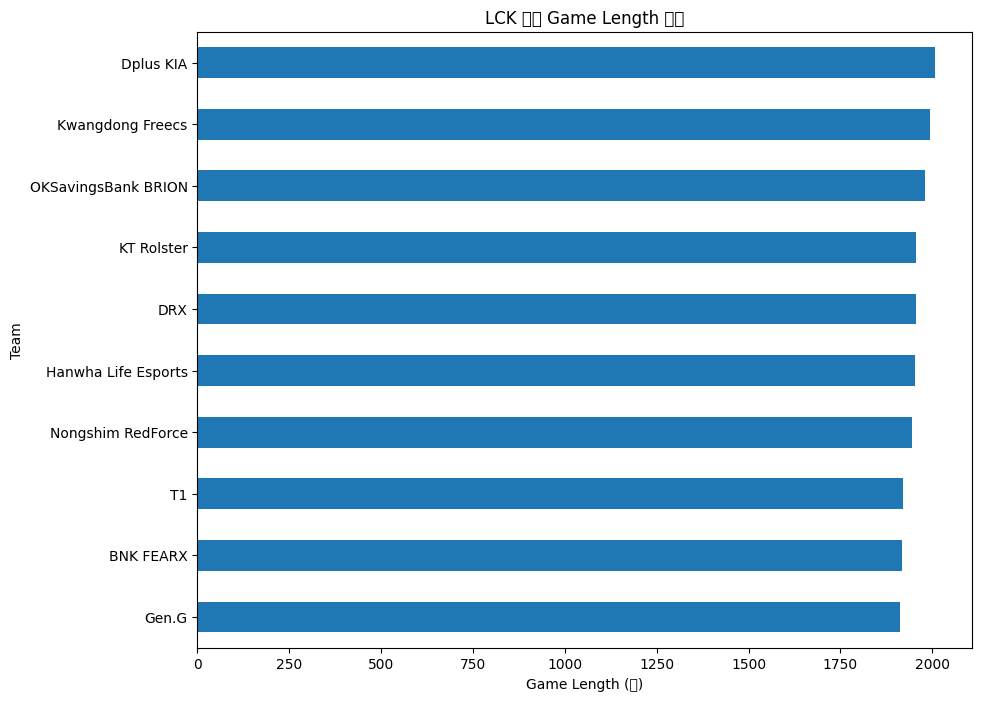

In [8]:
# 팀 이름 통합
train_data['teamname'] = train_data['teamname'].replace(team_name_mapping)

# LCK 팀 데이터 필터링
lck_teams = train_data[train_data['league'] == 'LCK']

# 숫자 데이터만 선택하여 그룹화
numeric_columns = lck_teams.select_dtypes(include=['number'])
lck_grouped = numeric_columns.groupby(lck_teams['teamname']).mean()

# 특정 지표를 선택해 시각화(경기시간)
if 'gamelength' in lck_grouped.columns:
    lck_grouped['gamelength'].sort_values().plot(kind='barh', figsize=(10, 8))
    plt.title('LCK 팀별 Game Length 평균')
    plt.xlabel('Game Length (분)')
    plt.ylabel('Team')
    plt.show()
else:
    print("데이터에 'gamelength' 열이 없습니다. 다른 지표를 사용해주세요.")


골드

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54016 (\N{HANGUL SYLLABLE TIM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54217 (\N{HANGUL SYLLABLE PYEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44512 (\N{HANGUL SYLLABLE GYUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


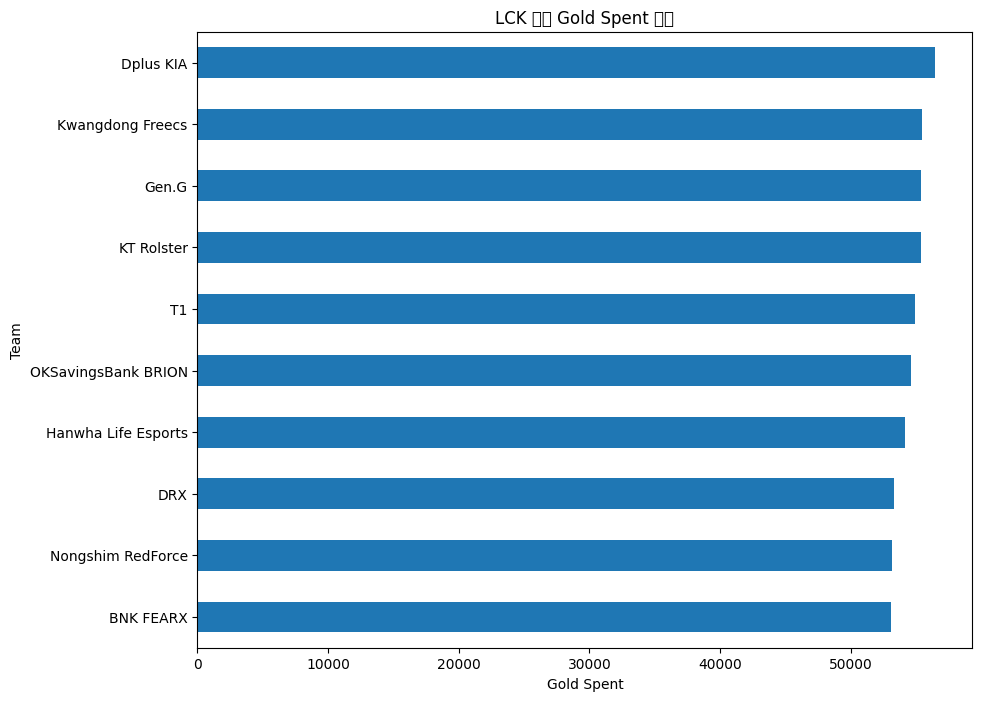

In [ ]:
# 특정 지표를 선택해 시각화
if 'goldspent' in lck_grouped.columns:
    lck_grouped['goldspent'].sort_values().plot(kind='barh', figsize=(10, 8))
    plt.title('LCK 팀별 Gold Spent 평균')
    plt.xlabel('Gold Spent')
    plt.ylabel('Team')
    plt.show()
else:
    print("데이터에 'goldspent' 열이 없습니다. 다른 지표를 사용해주세요.")


KDA

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54016 (\N{HANGUL SYLLABLE TIM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54217 (\N{HANGUL SYLLABLE PYEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44512 (\N{HANGUL SYLLABLE GYUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


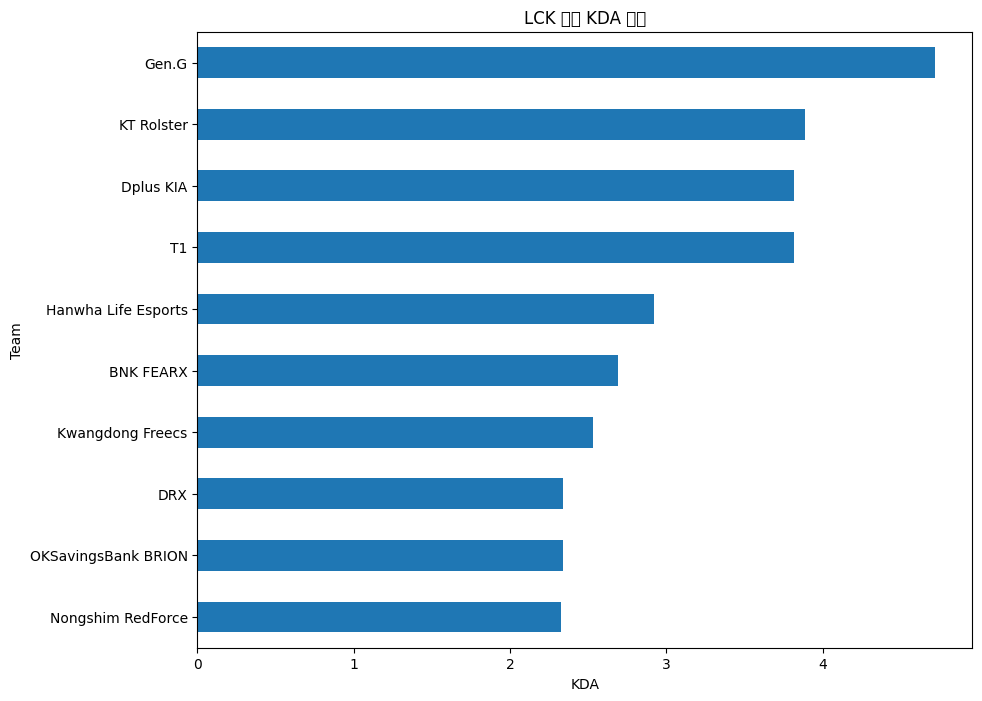

In [ ]:
# KDA 계산
if {'kills', 'deaths', 'assists'}.issubset(lck_grouped.columns):
    # KDA 계산 (데스가 0인 경우를 방지하기 위해 +1 추가)
    lck_grouped['KDA'] = (lck_grouped['kills'] + lck_grouped['assists']) / (lck_grouped['deaths'] + 1)

    # KDA 시각화
    lck_grouped['KDA'].sort_values().plot(kind='barh', figsize=(10, 8))
    plt.title('LCK 팀별 KDA 평균')
    plt.xlabel('KDA')
    plt.ylabel('Team')
    plt.show()
else:
    print("데이터에 'kills', 'deaths', 'assists' 열이 없습니다. 다른 지표를 사용해주세요.")


시야 점수

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54016 (\N{HANGUL SYLLABLE TIM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54217 (\N{HANGUL SYLLABLE PYEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44512 (\N{HANGUL SYLLABLE GYUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


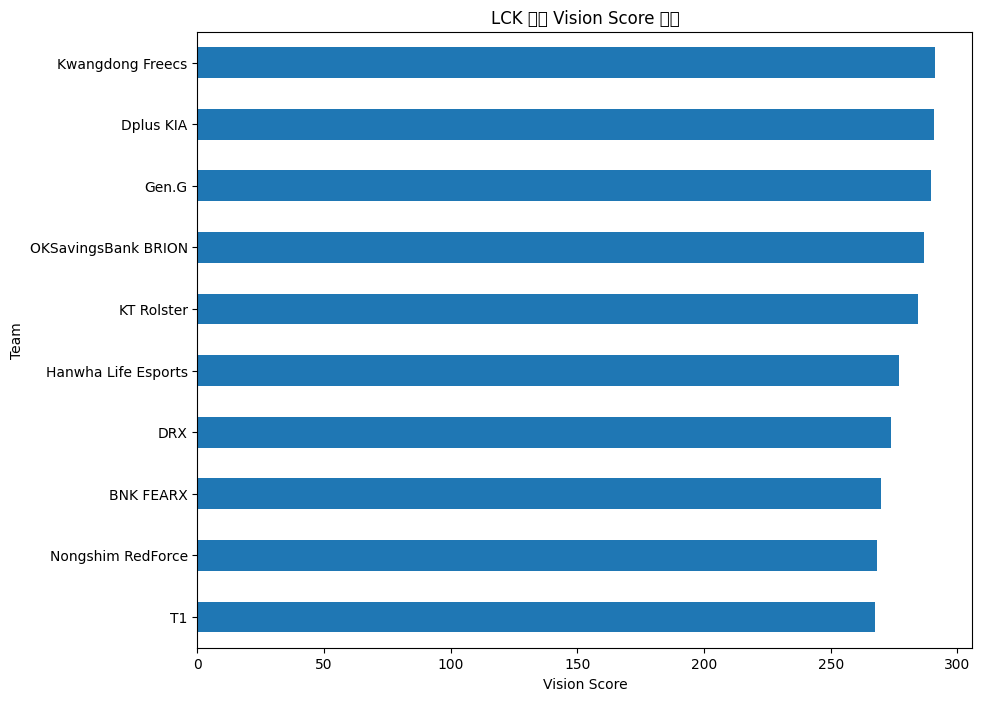

In [ ]:
# 'visionscore'를 이용하여 팀별 평균을 시각화하는 코드
if 'visionscore' in lck_grouped.columns:
    # 'visionscore' 시각화
    lck_grouped['visionscore'].sort_values().plot(kind='barh', figsize=(10, 8))
    plt.title('LCK 팀별 Vision Score 평균')
    plt.xlabel('Vision Score')
    plt.ylabel('Team')
    plt.show()
else:
    print("데이터에 'visionscore' 열이 없습니다. 다른 지표를 사용해주세요.")


15분 골드 차이

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54016 (\N{HANGUL SYLLABLE TIM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54217 (\N{HANGUL SYLLABLE PYEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44512 (\N{HANGUL SYLLABLE GYUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


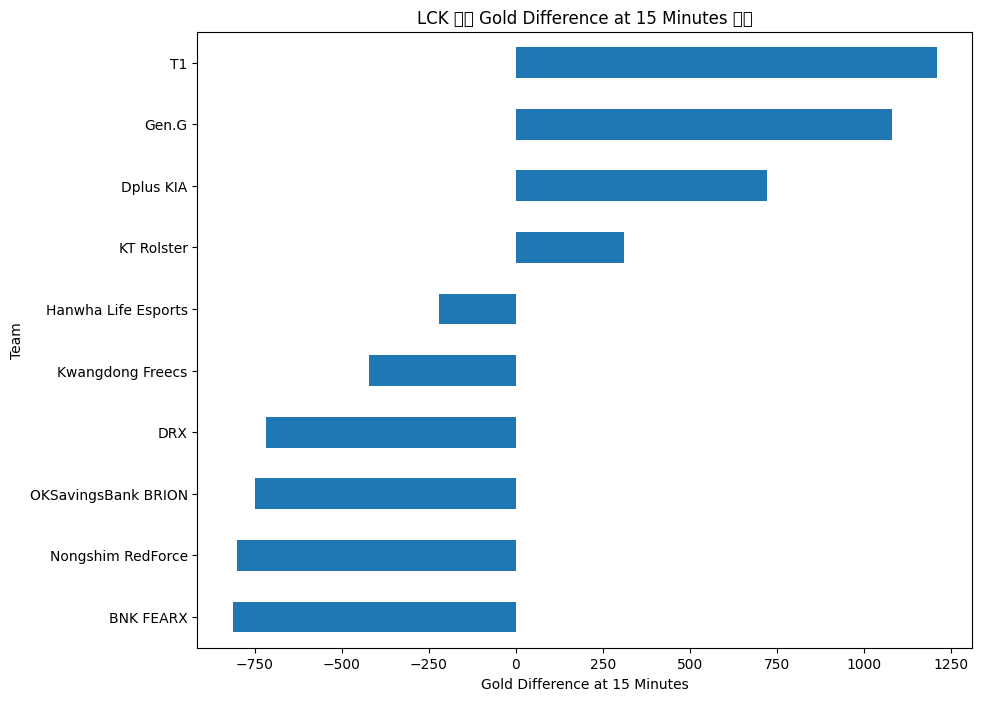

In [ ]:
# 'golddiffat15'를 이용하여 팀별 평균을 시각화하는 코드
if 'golddiffat15' in lck_grouped.columns:
    # 'golddiffat15' 시각화
    lck_grouped['golddiffat15'].sort_values().plot(kind='barh', figsize=(10, 8))
    plt.title('LCK 팀별 Gold Difference at 15 Minutes 평균')
    plt.xlabel('Gold Difference at 15 Minutes')
    plt.ylabel('Team')
    plt.show()
else:
    print("데이터에 'golddiffat15' 열이 없습니다. 다른 지표를 사용해주세요.")


#22년 LCK

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45380 (\N{HANGUL SYLLABLE NYEON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54016 (\N{HANGUL SYLLABLE TIM}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48143 (\N{HANGUL SYLLABLE MIC}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54217 (\N{HANGUL SYLLABLE PYEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw

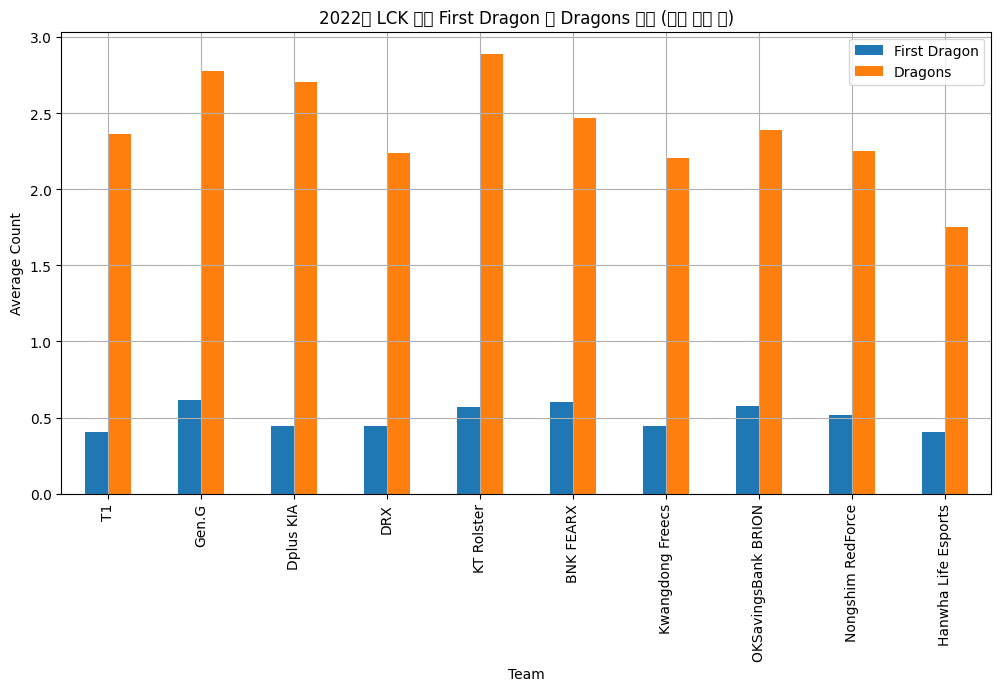

In [ ]:
# 2022년 LCK 팀 데이터 필터링
lck_2022 = train_data[(train_data['year'] == 2022) & (train_data['league'] == 'LCK')]

# 팀별 승리 횟수 계산 및 정렬
if {'teamname', 'result', 'firstdragon', 'dragons'}.issubset(lck_2022.columns):
    win_counts = lck_2022[lck_2022['result'] == 1].groupby('teamname')['result'].count()

    # 팀별 첫 번째 드래곤 및 드래곤 획득 수 평균 계산
    dragon_stats = lck_2022.groupby('teamname')[['firstdragon', 'dragons']].mean()

    # 승리 횟수 기준으로 데이터 정렬
    dragon_stats = dragon_stats.loc[win_counts.sort_values(ascending=False).index]

    # 시각화
    dragon_stats.plot(kind='bar', figsize=(12, 6))
    plt.title('2022년 LCK 팀별 First Dragon 및 Dragons 평균 (승리 횟수 순)')
    plt.xlabel('Team')
    plt.ylabel('Average Count')
    plt.legend(['First Dragon', 'Dragons'], loc='best')
    plt.xticks(rotation=90)
    plt.grid(True)
    plt.show()
else:
    print("데이터에 'teamname', 'result', 'firstdragon', 'dragons' 열이 없습니다.")

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45380 (\N{HANGUL SYLLABLE NYEON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54016 (\N{HANGUL SYLLABLE TIM}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48143 (\N{HANGUL SYLLABLE MIC}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/

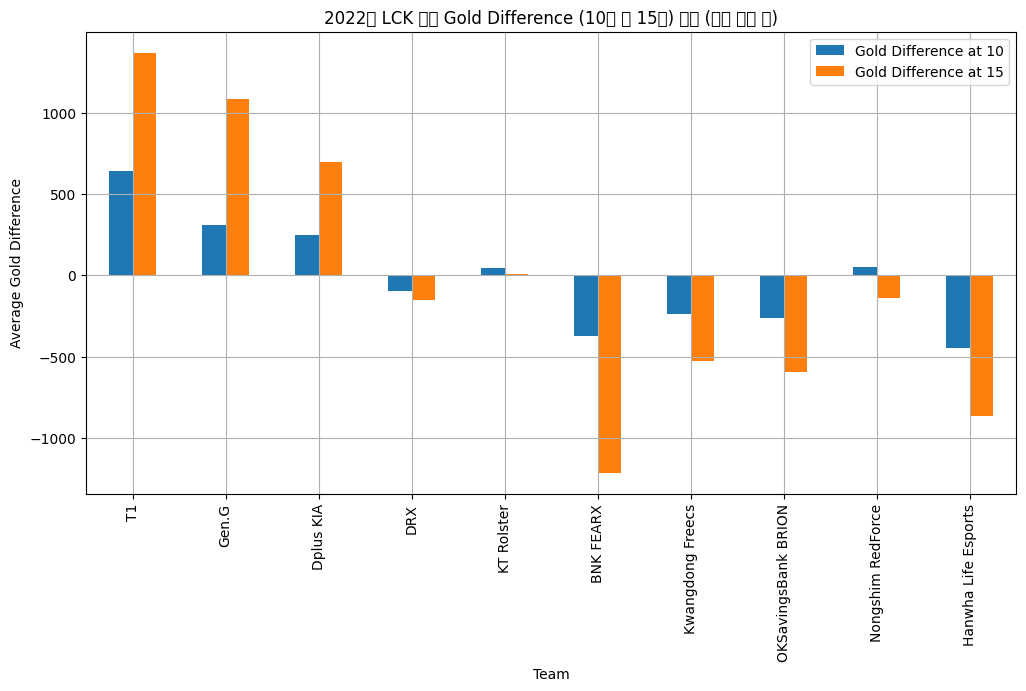

In [ ]:
# 팀별 승리 횟수 계산 및 정렬
if {'teamname', 'result', 'golddiffat10', 'golddiffat15'}.issubset(lck_2022.columns):
    win_counts = lck_2022[lck_2022['result'] == 1].groupby('teamname')['result'].count()

    # 팀별 골드 차이 평균 계산
    gold_diff_stats = lck_2022.groupby('teamname')[['golddiffat10', 'golddiffat15']].mean()

    # 승리 횟수 기준으로 데이터 정렬
    gold_diff_stats = gold_diff_stats.loc[win_counts.sort_values(ascending=False).index]

    # 시각화
    gold_diff_stats.plot(kind='bar', figsize=(12, 6))
    plt.title('2022년 LCK 팀별 Gold Difference (10분 및 15분) 평균 (승리 횟수 순)')
    plt.xlabel('Team')
    plt.ylabel('Average Gold Difference')
    plt.legend(['Gold Difference at 10', 'Gold Difference at 15'], loc='best')
    plt.xticks(rotation=90)
    plt.grid(True)
    plt.show()
else:
    print("데이터에 'teamname', 'result', 'golddiffat10', 'golddiffat15' 열이 없습니다.")

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45380 (\N{HANGUL SYLLABLE NYEON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54016 (\N{HANGUL SYLLABLE TIM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48143 (\N{HANGUL SYLLABLE MIC}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packa

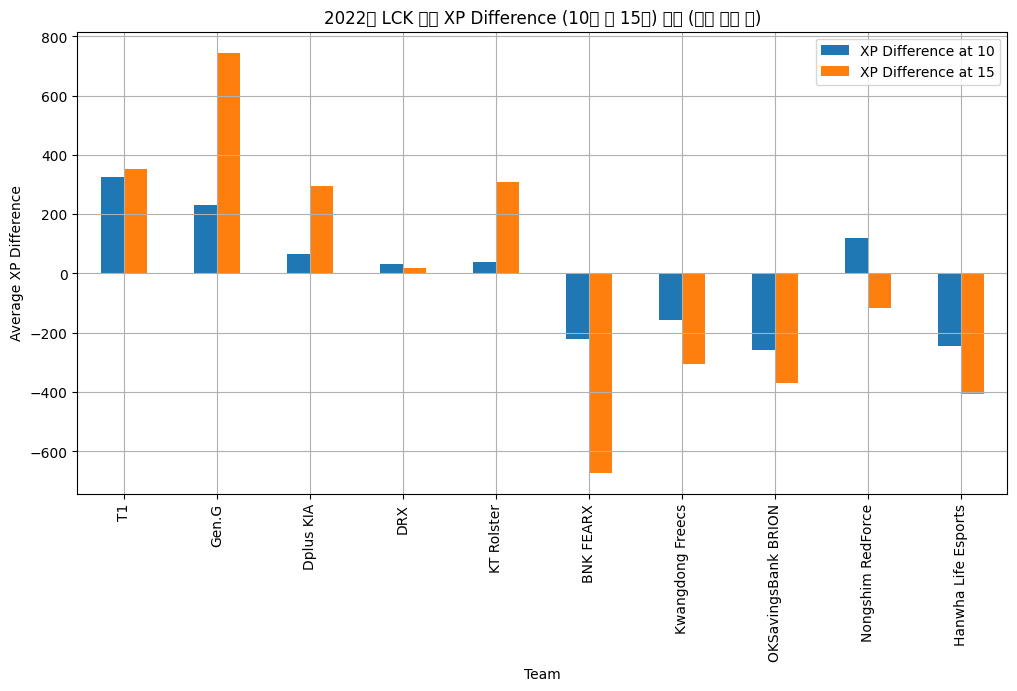

In [ ]:
# 팀별 승리 횟수 계산 및 정렬
if {'teamname', 'result', 'xpdiffat10', 'xpdiffat15'}.issubset(lck_2022.columns):
    win_counts = lck_2022[lck_2022['result'] == 1].groupby('teamname')['result'].count()

    # 팀별 경험치 차이 평균 계산
    xp_diff_stats = lck_2022.groupby('teamname')[['xpdiffat10', 'xpdiffat15']].mean()

    # 승리 횟수 기준으로 데이터 정렬
    xp_diff_stats = xp_diff_stats.loc[win_counts.sort_values(ascending=False).index]

    # 시각화
    xp_diff_stats.plot(kind='bar', figsize=(12, 6))
    plt.title('2022년 LCK 팀별 XP Difference (10분 및 15분) 평균 (승리 횟수 순)')
    plt.xlabel('Team')
    plt.ylabel('Average XP Difference')
    plt.legend(['XP Difference at 10', 'XP Difference at 15'], loc='best')
    plt.xticks(rotation=90)
    plt.grid(True)
    plt.show()
else:
    print("데이터에 'teamname', 'result', 'xpdiffat10', 'xpdiffat15' 열이 없습니다.")

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45380 (\N{HANGUL SYLLABLE NYEON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54016 (\N{HANGUL SYLLABLE TIM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48143 (\N{HANGUL SYLLABLE MIC}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packa

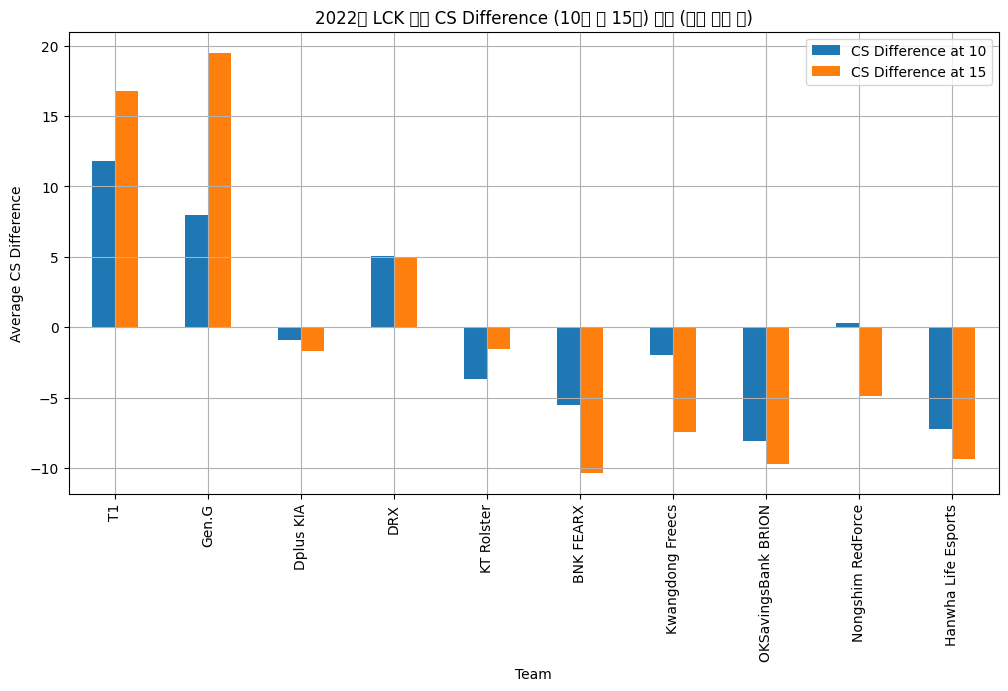

In [ ]:
# 팀별 승리 횟수 계산 및 정렬
if {'teamname', 'result', 'csdiffat10', 'csdiffat15'}.issubset(lck_2022.columns):
    win_counts = lck_2022[lck_2022['result'] == 1].groupby('teamname')['result'].count()

    # 팀별 CS 차이 평균 계산
    cs_diff_stats = lck_2022.groupby('teamname')[['csdiffat10', 'csdiffat15']].mean()

    # 승리 횟수 기준으로 데이터 정렬
    cs_diff_stats = cs_diff_stats.loc[win_counts.sort_values(ascending=False).index]

    # 시각화
    cs_diff_stats.plot(kind='bar', figsize=(12, 6))
    plt.title('2022년 LCK 팀별 CS Difference (10분 및 15분) 평균 (승리 횟수 순)')
    plt.xlabel('Team')
    plt.ylabel('Average CS Difference')
    plt.legend(['CS Difference at 10', 'CS Difference at 15'], loc='best')
    plt.xticks(rotation=90)
    plt.grid(True)
    plt.show()
else:
    print("데이터에 'teamname', 'result', 'csdiffat10', 'csdiffat15' 열이 없습니다.")

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49849 (\N{HANGUL SYLLABLE SEUNG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47532 (\N{HANGUL SYLLABLE RI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50668 (\N{HANGUL SYLLABLE YEO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48512 (\N{HANGUL SYLLABLE BU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50752 (\N{HANGUL SYLLABLE WA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/I

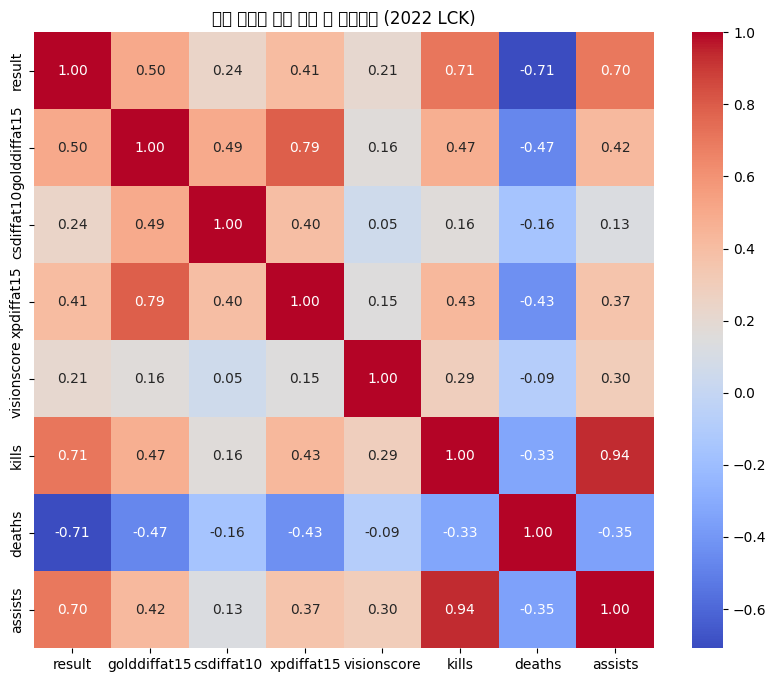

In [ ]:
# 주요 변수와 승리 여부 간의 상관관계 분석
important_columns = ['result', 'golddiffat15', 'csdiffat10', 'xpdiffat15', 'visionscore', 'kills', 'deaths', 'assists']
if all(col in lck_2022.columns for col in important_columns):
    correlation_matrix = lck_2022[important_columns].corr()

    # 히트맵으로 시각화
    import seaborn as sns
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('승리 여부와 주요 변수 간 상관관계 (2022 LCK)')
    plt.show()
else:
    print("데이터에 필요한 열이 없습니다.")


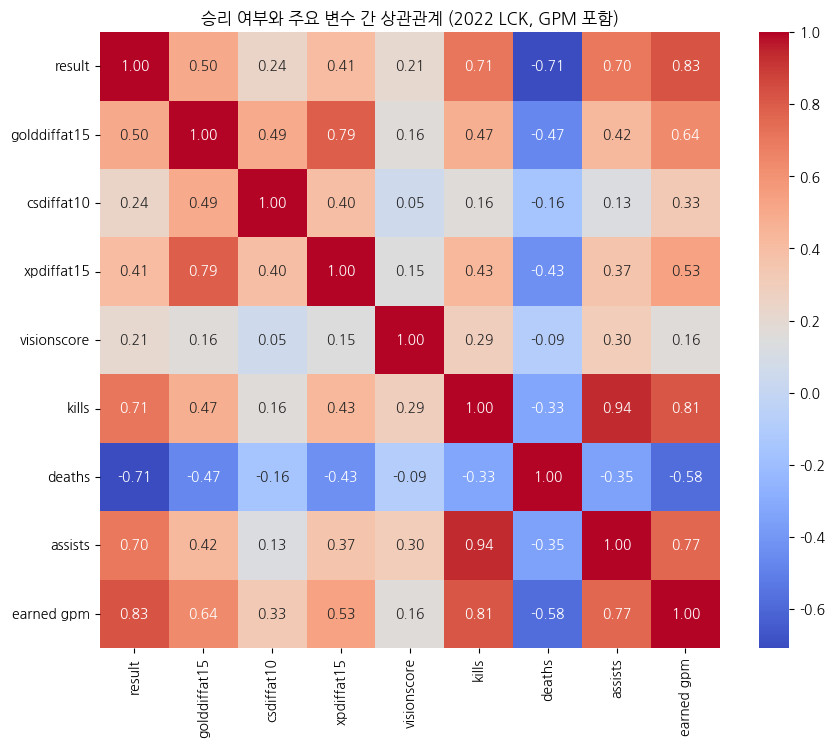

In [ ]:
# 주요 변수와 승리 여부 간의 상관관계 분석 (GPM 추가)
important_columns = ['result', 'golddiffat15', 'csdiffat10', 'xpdiffat15', 'visionscore', 'kills', 'deaths', 'assists', 'earned gpm']

if all(col in lck_2022.columns for col in important_columns):
    correlation_matrix = lck_2022[important_columns].corr()

    # 히트맵으로 시각화
    import seaborn as sns
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('승리 여부와 주요 변수 간 상관관계 (2022 LCK, GPM 포함)')
    plt.show()
else:
    print("데이터에 필요한 열이 없습니다.")


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49849 (\N{HANGUL SYLLABLE SEUNG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47532 (\N{HANGUL SYLLABLE RI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54016 (\N{HANGUL SYLLABLE TIM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54056 (\N{HANGUL SYLLABLE PAE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48176 (\N{HANGUL SYLLABLE BAE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages

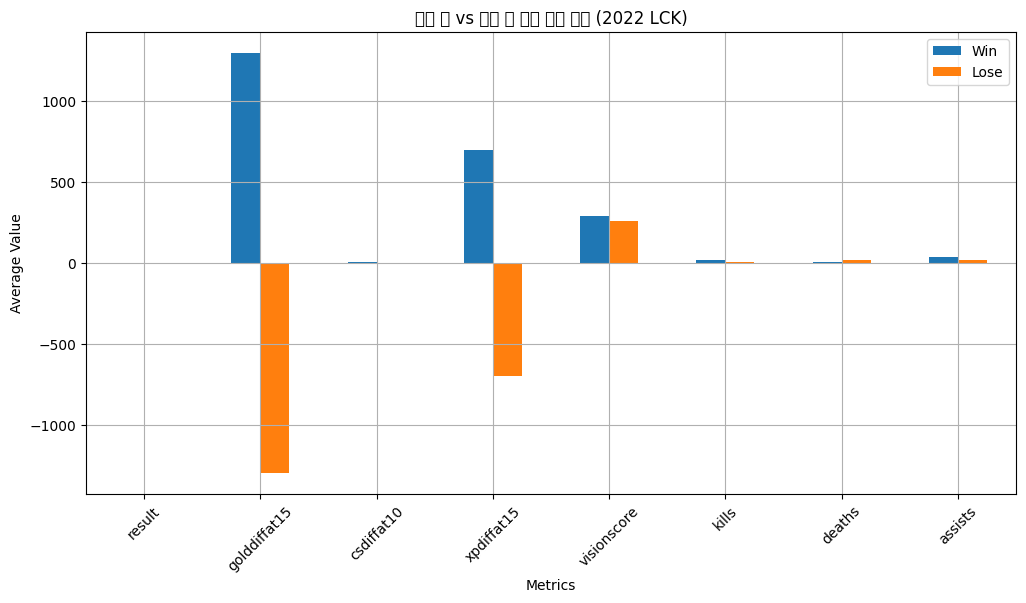

In [ ]:
# 승리 팀과 패배 팀의 주요 변수 평균 비교
if all(col in lck_2022.columns for col in important_columns):
    win_stats = lck_2022[lck_2022['result'] == 1][important_columns].mean()
    lose_stats = lck_2022[lck_2022['result'] == 0][important_columns].mean()

    comparison = pd.DataFrame({'Win': win_stats, 'Lose': lose_stats})
    comparison.plot(kind='bar', figsize=(12, 6))
    plt.title('승리 팀 vs 패배 팀 주요 지표 비교 (2022 LCK)')
    plt.xlabel('Metrics')
    plt.ylabel('Average Value')
    plt.xticks(rotation=45)
    plt.legend(['Win', 'Lose'])
    plt.grid(True)
    plt.show()
else:
    print("데이터에 필요한 열이 없습니다.")


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44264 (\N{HANGUL SYLLABLE GOL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 46300 (\N{HANGUL SYLLABLE DEU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPy

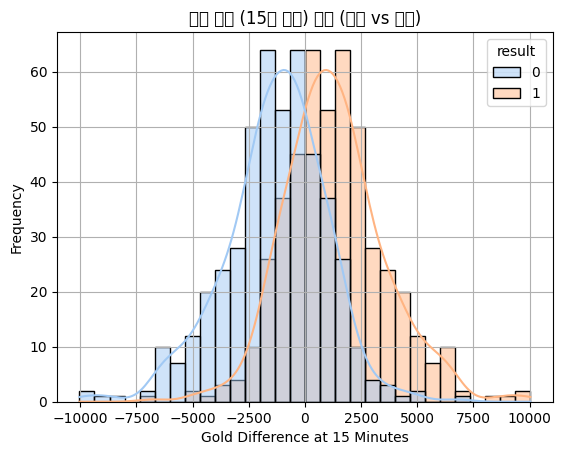

In [ ]:
# 골드 차이(golddiffat15)의 승리/패배 분포 확인
if 'golddiffat15' in lck_2022.columns:
    import seaborn as sns
    sns.histplot(data=lck_2022, x='golddiffat15', hue='result', kde=True, bins=30, palette='pastel')
    plt.title('골드 차이 (15분 기준) 분포 (승리 vs 패배)')
    plt.xlabel('Gold Difference at 15 Minutes')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()
else:
    print("데이터에 'golddiffat15' 열이 없습니다.")


한글

In [20]:
import matplotlib
from matplotlib import font_manager

!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv

fontpaths = ["/usr/share/fonts/truetype/nanum/"]
font_files = font_manager.findSystemFonts(fontpaths=fontpaths)

for ff in font_files:
    font_manager.fontManager.addfont(ff)

matplotlib.rc('font', family="NanumGothic")
matplotlib.rcParams['axes.unicode_minus'] = False

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 49 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 1s (10.6 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 123632 files and direc

<ipython-input-12-5daeab58afd3>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lck_data['gamelength_minutes'] = lck_data['gamelength'] / 60


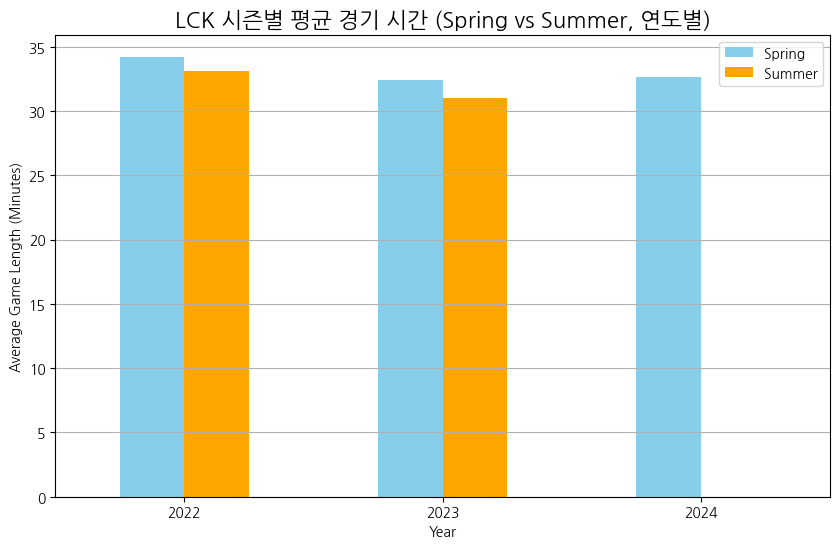

In [ ]:
if 'league' in train_data.columns and 'split' in train_data.columns:
    lck_data = train_data[train_data['league'] == 'LCK']

    # 경기 시간 초 → 분 변환
    lck_data['gamelength_minutes'] = lck_data['gamelength'] / 60

    # 시즌(Spring/Summer)별 평균 경기 시간 계산
    gamelength_by_split = lck_data.groupby(['year', 'split'])['gamelength_minutes'].mean().unstack()

    # 시각화
    gamelength_by_split.plot(kind='bar', figsize=(10, 6), color=['skyblue', 'orange'])
    plt.title('LCK 시즌별 평균 경기 시간 (Spring vs Summer, 연도별)', fontsize=16)
    plt.xlabel('Year')
    plt.ylabel('Average Game Length (Minutes)')
    plt.legend(['Spring', 'Summer'], fontsize=10)
    plt.xticks(rotation=0)
    plt.grid(axis='y')
    plt.show()
else:
    print("데이터에 'league' 또는 'split' 열이 없습니다.")

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51596 (\N{HANGUL SYLLABLE JEUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50724 (\N{HANGUL SYLLABLE O}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48652 (\N{HANGUL SYLLABLE BEU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/

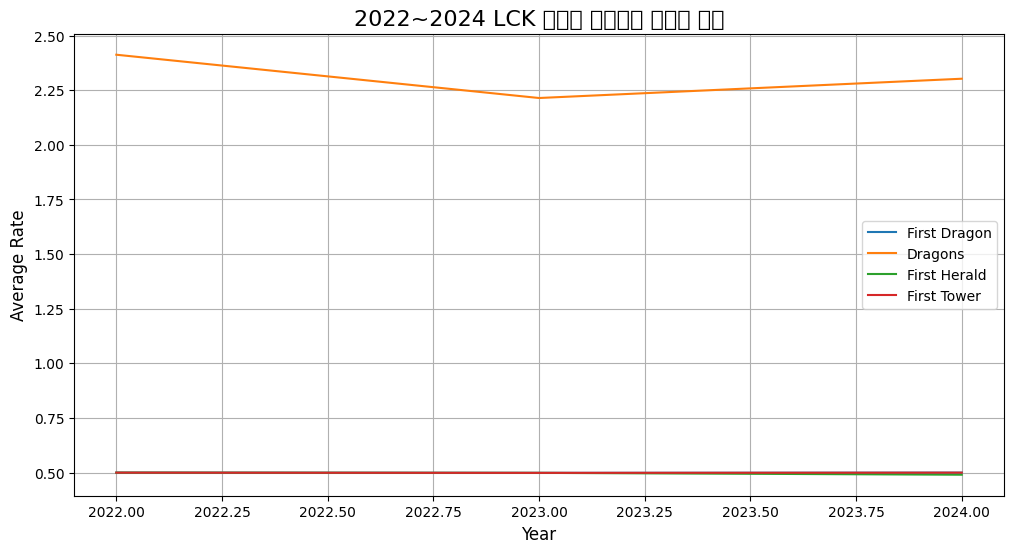

In [ ]:
# if 'league' in train_data.columns:
#     lck_data = train_data[train_data['league'] == 'LCK']

#     # 시즌별 드래곤 및 오브젝트 중요도 분석
#     objectives = lck_data.groupby('year')[['firstdragon', 'dragons', 'firstherald', 'firsttower']].mean()
#     objectives.plot(kind='line', figsize=(12, 6))

#     # 시각화 설정
#     plt.title('2022~2024 LCK 시즌별 오브젝트 중요도 변화', fontsize=16)
#     plt.xlabel('Year', fontsize=12)
#     plt.ylabel('Average Rate', fontsize=12)
#     plt.legend(['First Dragon', 'Dragons', 'First Herald', 'First Tower'], fontsize=10)
#     plt.grid(True)
#     plt.show()
# else:
#     print("데이터에 'league' 열이 없습니다. LCK 분석을 위해 해당 열이 필요합니다.")


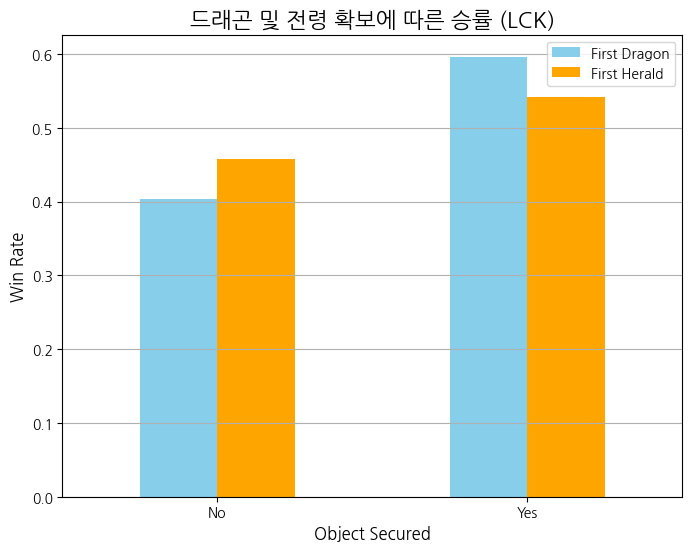

In [ ]:
# 드래곤과 전령 확보 여부에 따른 승률 분석
if 'firstdragon' in lck_data.columns and 'firstherald' in lck_data.columns and 'result' in lck_data.columns:
    object_win_rates = lck_data.groupby('firstdragon')['result'].mean().rename('First Dragon Win Rate').to_frame()
    object_win_rates['Herald Win Rate'] = lck_data.groupby('firstherald')['result'].mean()

    # 시각화
    object_win_rates.plot(kind='bar', figsize=(8, 6), color=['skyblue', 'orange'])
    plt.title('드래곤 및 전령 확보에 따른 승률 (LCK)', fontsize=16)
    plt.xlabel('Object Secured', fontsize=12)
    plt.ylabel('Win Rate', fontsize=12)
    plt.legend(['First Dragon', 'First Herald'], fontsize=10)
    plt.xticks([0, 1], labels=['No', 'Yes'], rotation=0)
    plt.grid(axis='y')
    plt.show()
else:
    print("데이터에 'firstdragon', 'firstherald', 'result' 열이 필요합니다.")


<ipython-input-10-239494bcaf6b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lck_data['first_object'] = lck_data.apply(


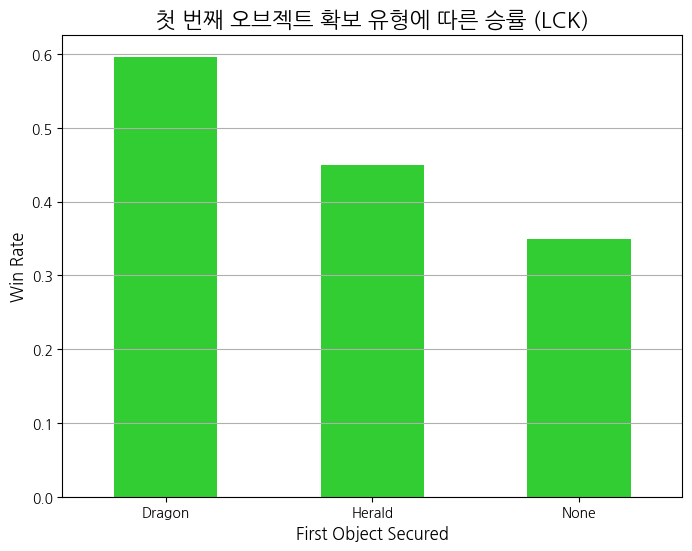

In [ ]:
# # 오브젝트 획득 순서와 승률 분석
# if 'firstdragon' in lck_data.columns and 'firstherald' in lck_data.columns and 'result' in lck_data.columns:
#     lck_data['first_object'] = lck_data.apply(
#         lambda row: 'Dragon' if row['firstdragon'] == 1 else ('Herald' if row['firstherald'] == 1 else 'None'),
#         axis=1
#     )
#     first_object_win_rate = lck_data.groupby('first_object')['result'].mean()

#     # 시각화
#     first_object_win_rate.plot(kind='bar', color='limegreen', figsize=(8, 6))
#     plt.title('첫 번째 오브젝트 확보 유형에 따른 승률 (LCK)', fontsize=16)
#     plt.xlabel('First Object Secured', fontsize=12)
#     plt.ylabel('Win Rate', fontsize=12)
#     plt.xticks(rotation=0)
#     plt.grid(axis='y')
#     plt.show()
# else:
#     print("데이터에 'firstdragon', 'firstherald', 'result' 열이 필요합니다.")


<ipython-input-27-e3b4f15c17d6>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pre_patch_14_data['first_object'] = pre_patch_14_data.apply(


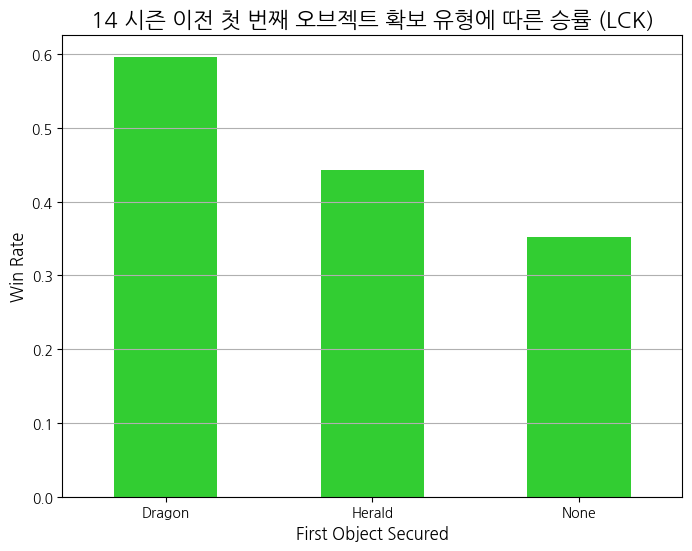

In [ ]:
# 오브젝트 획득 순서와 승률 분석 (14 시즌 이전 데이터로)
if {'firstdragon', 'firstherald', 'result', 'patch'}.issubset(lck_data.columns):
    # 14 시즌 이전 데이터 필터링
    pre_patch_14_data = lck_data[lck_data['patch'] < 14]

    # 첫 번째 오브젝트 유형 정의
    pre_patch_14_data['first_object'] = pre_patch_14_data.apply(
        lambda row: 'Dragon' if row['firstdragon'] == 1 else ('Herald' if row['firstherald'] == 1 else 'None'),
        axis=1
    )

    # 첫 번째 오브젝트 확보 유형에 따른 승률 계산
    first_object_win_rate = pre_patch_14_data.groupby('first_object')['result'].mean()

    # 시각화
    first_object_win_rate.plot(kind='bar', color='limegreen', figsize=(8, 6))
    plt.title('14 시즌 이전 첫 번째 오브젝트 확보 유형에 따른 승률 (LCK)', fontsize=16)
    plt.xlabel('First Object Secured', fontsize=12)
    plt.ylabel('Win Rate', fontsize=12)
    plt.xticks(rotation=0)
    plt.grid(axis='y')
    plt.show()
else:
    print("데이터에 'firstdragon', 'firstherald', 'result', 'patch' 열이 필요합니다.")


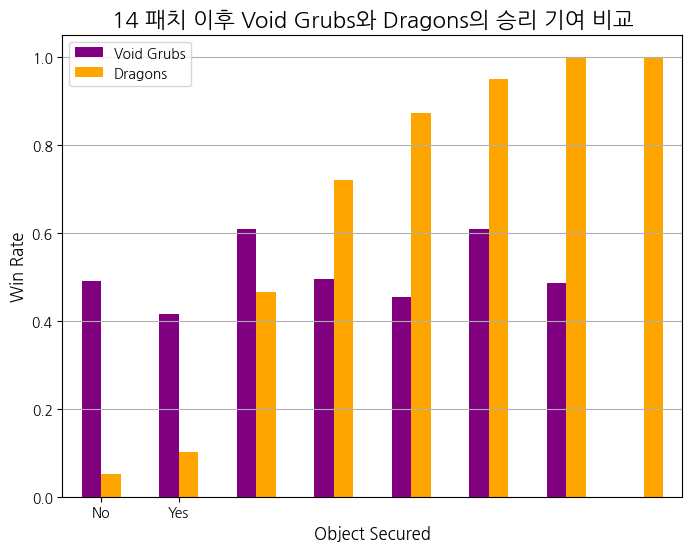

In [ ]:
# # LCK 데이터 필터링 및 14시즌 이후 void_grubs와 dragons 비교
# if 'patch' in train_data.columns and 'void_grubs' in train_data.columns and 'dragons' in train_data.columns:
#     # 14 패치 버전 이후 데이터 필터링
#     patch_14_data = train_data[(train_data['patch'] >= 14) & (train_data['league'] == 'LCK')]

#     # void_grubs와 dragons의 승률 비교
#     if 'result' in patch_14_data.columns:
#         void_grubs_win_rate = patch_14_data.groupby('void_grubs')['result'].mean()
#         dragons_win_rate = patch_14_data.groupby('dragons')['result'].mean()

#         # 데이터 정리
#         win_rates = pd.DataFrame({
#             'Void Grubs Win Rate': void_grubs_win_rate,
#             'Dragons Win Rate': dragons_win_rate
#         }).fillna(0)

#         # 시각화
#         win_rates.plot(kind='bar', figsize=(8, 6), color=['purple', 'orange'])
#         plt.title('14 패치 이후 Void Grubs와 Dragons의 승리 기여 비교', fontsize=16)
#         plt.xlabel('Object Secured', fontsize=12)
#         plt.ylabel('Win Rate', fontsize=12)
#         plt.xticks([0, 1], labels=['No', 'Yes'], rotation=0)
#         plt.legend(['Void Grubs', 'Dragons'], fontsize=10)
#         plt.grid(axis='y')
#         plt.show()
#     else:
#         print("데이터에 'result' 열이 없습니다. 승률 분석을 위해 필요합니다.")
# else:
#     print("데이터에 'patch', 'void_grubs', 'dragons' 열이 없습니다. 해당 열이 필요합니다.")


<ipython-input-16-6a5af5d9e22a>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_14_data['void_grubs_secured'] = patch_14_data['void_grubs'] >= 4


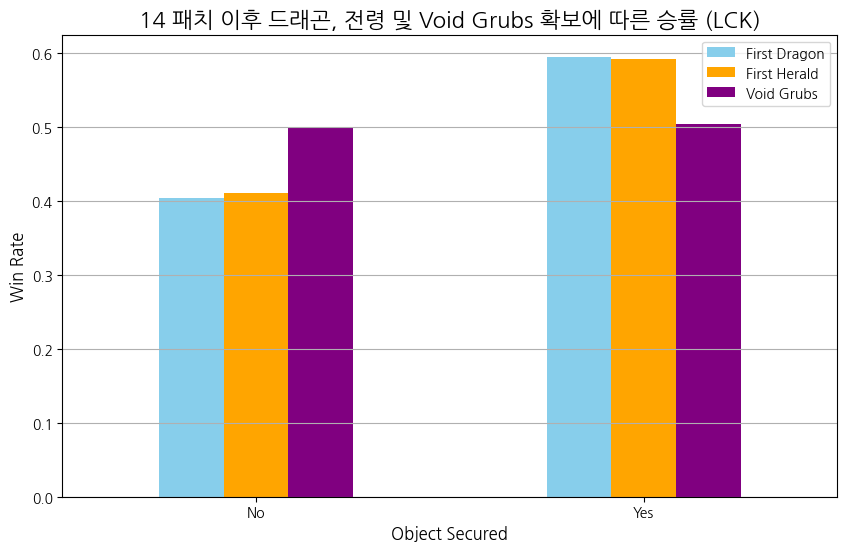

In [ ]:
# # 14 시즌 이후의 데이터 필터링 및 드래곤, 전령, Void Grubs 확보 여부에 따른 승률 분석
# if {'firstdragon', 'firstherald', 'void_grubs', 'result', 'patch'}.issubset(lck_data.columns):
#     # 14 패치 이후 데이터 필터링
#     patch_14_data = lck_data[lck_data['patch'] >= 14]

#     # Void Grubs를 4개 이상 확보한 경우를 확보로 간주
#     patch_14_data['void_grubs_secured'] = patch_14_data['void_grubs'] >= 4

#     # 승률 계산
#     object_win_rates = patch_14_data.groupby('firstdragon')['result'].mean().rename('First Dragon Win Rate').to_frame()
#     object_win_rates['Herald Win Rate'] = patch_14_data.groupby('firstherald')['result'].mean()
#     object_win_rates['Void Grubs Win Rate'] = patch_14_data.groupby('void_grubs_secured')['result'].mean()

#     # 시각화
#     object_win_rates.plot(kind='bar', figsize=(10, 6), color=['skyblue', 'orange', 'purple'])
#     plt.title('14 패치 이후 드래곤, 전령 및 Void Grubs 확보에 따른 승률 (LCK)', fontsize=16)
#     plt.xlabel('Object Secured', fontsize=12)
#     plt.ylabel('Win Rate', fontsize=12)
#     plt.legend(['First Dragon', 'First Herald', 'Void Grubs'], fontsize=10)
#     plt.xticks([0, 1], labels=['No', 'Yes'], rotation=0)
#     plt.grid(axis='y')
#     plt.show()
# else:
#     print("데이터에 'firstdragon', 'firstherald', 'void_grubs', 'result', 'patch' 열이 필요합니다.")


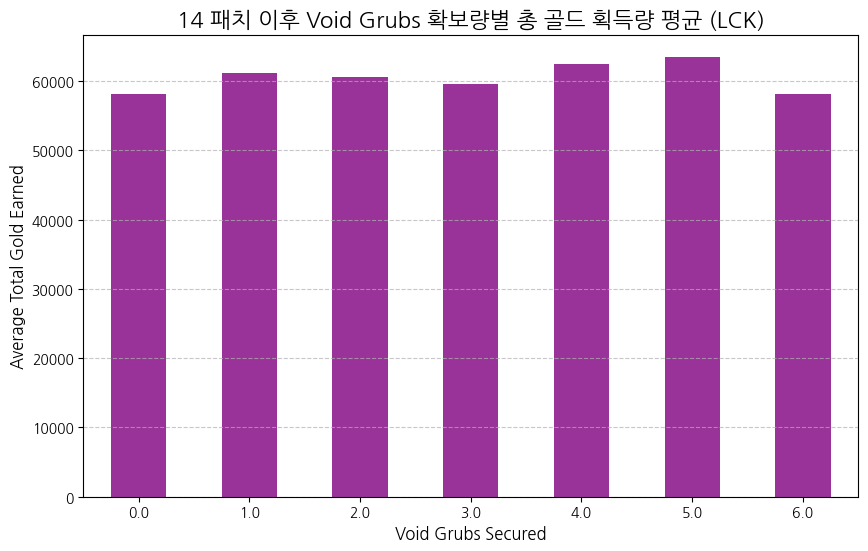

In [ ]:
# # Void Grubs와 총 골드 획득량의 평균값을 깔끔하게 시각화
# if {'void_grubs', 'totalgold', 'patch'}.issubset(lck_data.columns):
#     # 14 패치 이후 데이터 필터링
#     patch_14_data = lck_data[lck_data['patch'] >= 14]

#     # Void Grubs 확보량별 총 골드 획득량 평균 계산
#     avg_gold_by_void_grubs = patch_14_data.groupby('void_grubs')['totalgold'].mean()

#     # 시각화
#     avg_gold_by_void_grubs.plot(kind='bar', figsize=(10, 6), color='purple', alpha=0.8)
#     plt.title('14 패치 이후 Void Grubs 확보량별 총 골드 획득량 평균 (LCK)', fontsize=16)
#     plt.xlabel('Void Grubs Secured', fontsize=12)
#     plt.ylabel('Average Total Gold Earned', fontsize=12)
#     plt.xticks(rotation=0)
#     plt.grid(axis='y', linestyle='--', alpha=0.7)
#     plt.show()
# else:
#     print("데이터에 'void_grubs', 'totalgold', 'patch' 열이 필요합니다.")



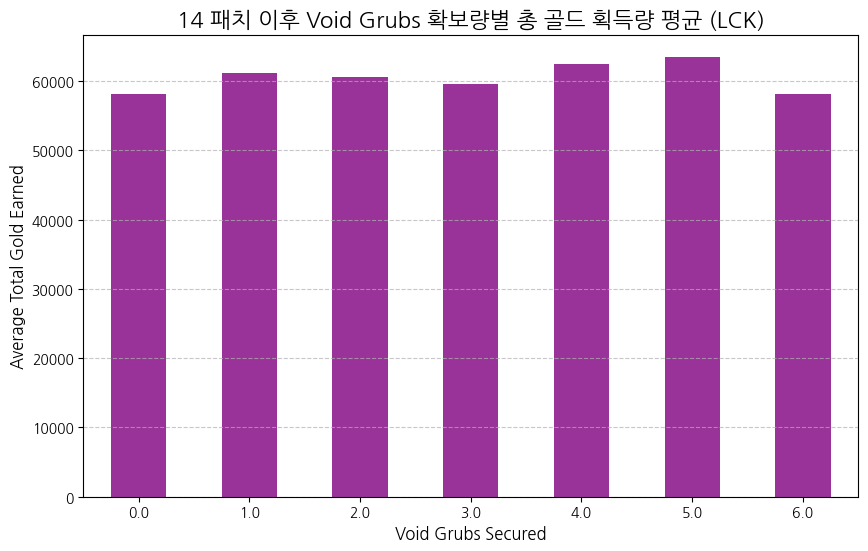

In [ ]:
# # Void Grubs 확보량별 총 골드 획득량의 평균값 막대 그래프
# if {'void_grubs', 'totalgold', 'patch'}.issubset(lck_data.columns):
#     # 14 패치 이후 데이터 필터링
#     patch_14_data = lck_data[lck_data['patch'] >= 14]

#     # Void Grubs 확보량별 총 골드 획득량 평균 계산
#     avg_gold_by_void_grubs = patch_14_data.groupby('void_grubs')['totalgold'].mean()

#     # 시각화
#     avg_gold_by_void_grubs.plot(kind='bar', figsize=(10, 6), color='purple', alpha=0.8)
#     plt.title('14 패치 이후 Void Grubs 확보량별 총 골드 획득량 평균 (LCK)', fontsize=16)
#     plt.xlabel('Void Grubs Secured', fontsize=12)
#     plt.ylabel('Average Total Gold Earned', fontsize=12)
#     plt.xticks(rotation=0)
#     plt.grid(axis='y', linestyle='--', alpha=0.7)
#     plt.show()
# else:
#     print("데이터에 'void_grubs', 'totalgold', 'patch' 열이 필요합니다.")


<ipython-input-22-ab176bea5003>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='void_grubs', y='totalgold', data=patch_14_data, palette='Purples')


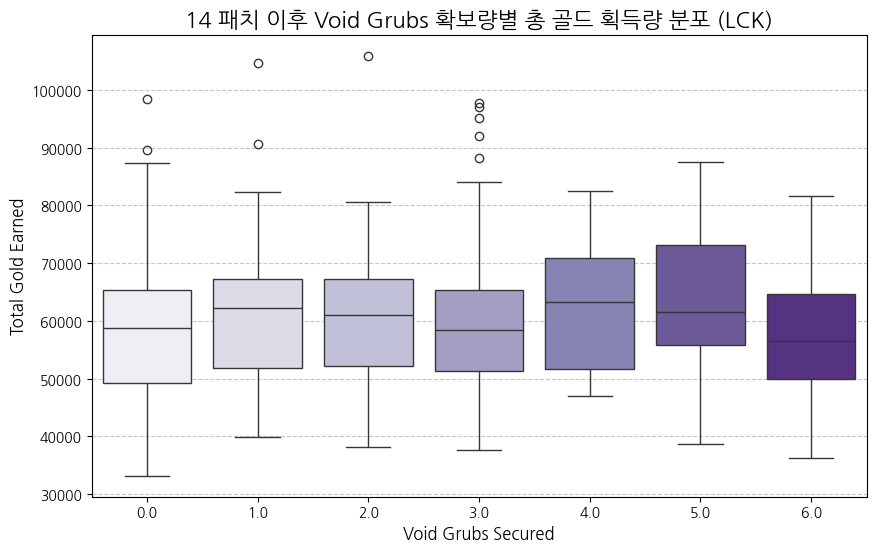

In [ ]:
import seaborn as sns  # Seaborn 임포트

# # Void Grubs 확보량별 총 골드 획득량 박스플롯
# if {'void_grubs', 'totalgold', 'patch'}.issubset(lck_data.columns):
#     # 14 패치 이후 데이터 필터링
#     patch_14_data = lck_data[lck_data['patch'] >= 14]

#     # 시각화
#     plt.figure(figsize=(10, 6))
#     sns.boxplot(x='void_grubs', y='totalgold', data=patch_14_data, palette='Purples')
#     plt.title('14 패치 이후 Void Grubs 확보량별 총 골드 획득량 분포 (LCK)', fontsize=16)
#     plt.xlabel('Void Grubs Secured', fontsize=12)
#     plt.ylabel('Total Gold Earned', fontsize=12)
#     plt.grid(axis='y', linestyle='--', alpha=0.7)
#     plt.show()
# else:
#     print("데이터에 'void_grubs', 'totalgold', 'patch' 열이 필요합니다.")



유충

<ipython-input-23-388143d9f8a4>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='void_grubs', y='earned gpm', data=patch_14_data, palette='Purples')


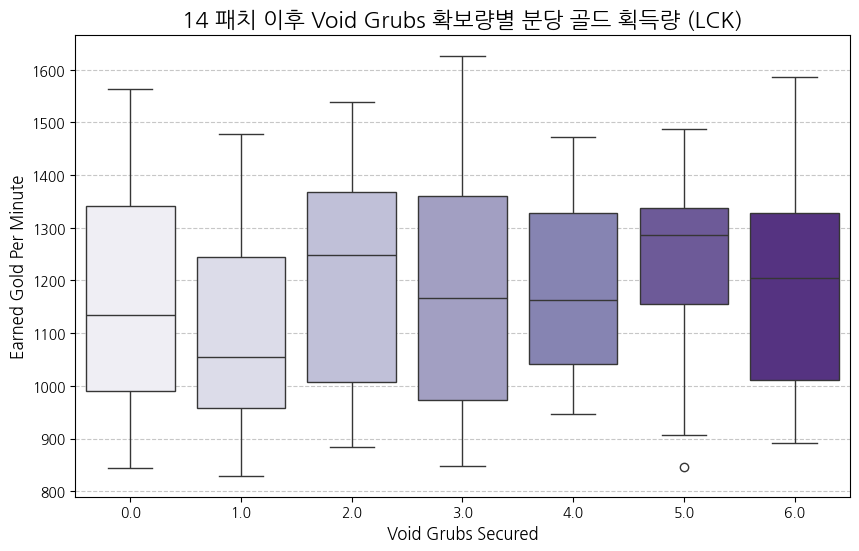

In [ ]:
# Void Grubs 확보량별 분당 골드 획득량 (earned gpm) 박스플롯
if {'void_grubs', 'earned gpm', 'patch'}.issubset(lck_data.columns):
    # 14 패치 이후 데이터 필터링
    patch_14_data = lck_data[lck_data['patch'] >= 14]

    # 시각화
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='void_grubs', y='earned gpm', data=patch_14_data, palette='Purples')
    plt.title('14 패치 이후 Void Grubs 확보량별 분당 골드 획득량 (LCK)', fontsize=16)
    plt.xlabel('Void Grubs Secured', fontsize=12)
    plt.ylabel('Earned Gold Per Minute', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
else:
    print("데이터에 'void_grubs', 'earned gpm', 'patch' 열이 필요합니다.")


In [ ]:
# Combine the two datasets into a single training dataset
combined_data = pd.concat([train_data, test_data], ignore_index=True)

# Display basic information and the first few rows of the combined dataset
combined_info = combined_data.info()
combined_head = combined_data.head()

(combined_info, combined_head)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12237 entries, 0 to 12236
Columns: 114 entries, gameid to pick1_count
dtypes: float64(79), int64(18), object(17)
memory usage: 10.6+ MB


(None,
                   gameid league   split  playoffs              date  game  \
 0  ESPORTSTMNT01_2700815    LCK  Spring         0   2022-01-12 6:20     1   
 1  ESPORTSTMNT01_2700815    LCK  Spring         0   2022-01-12 6:20     1   
 2  ESPORTSTMNT01_2690695    LCK  Spring         0   2022-01-12 9:02     2   
 3  ESPORTSTMNT01_2690695    LCK  Spring         0   2022-01-12 9:02     2   
 4  ESPORTSTMNT01_2690705    LCK  Spring         0  2022-01-12 10:07     1   
 
    patch  side   teamname      ban1  ... csdiffat15 killsat15 assistsat15  \
 0  12.01  Blue        DRX     Diana  ...        1.0       4.0         7.0   
 1  12.01   Red  BNK FEARX  Renekton  ...       -1.0       1.0         1.0   
 2  12.01  Blue        DRX     Diana  ...      -18.0       2.0         5.0   
 3  12.01   Red  BNK FEARX  Renekton  ...       18.0       4.0         5.0   
 4  12.01  Blue         T1   Lee Sin  ...      -15.0       3.0         2.0   
 
   deathsat15 opp_killsat15 opp_assistsat15 opp_death

In [ ]:
# !pip install seaborn

<ipython-input-37-8f3c9c210978>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_14_data['void_grubs'] = patch_14_data['void_grubs'].astype(float)
<ipython-input-37-8f3c9c210978>:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=sorted_void_grubs, patch_artist=True, boxprops=dict(facecolor="#D3CCE3"))


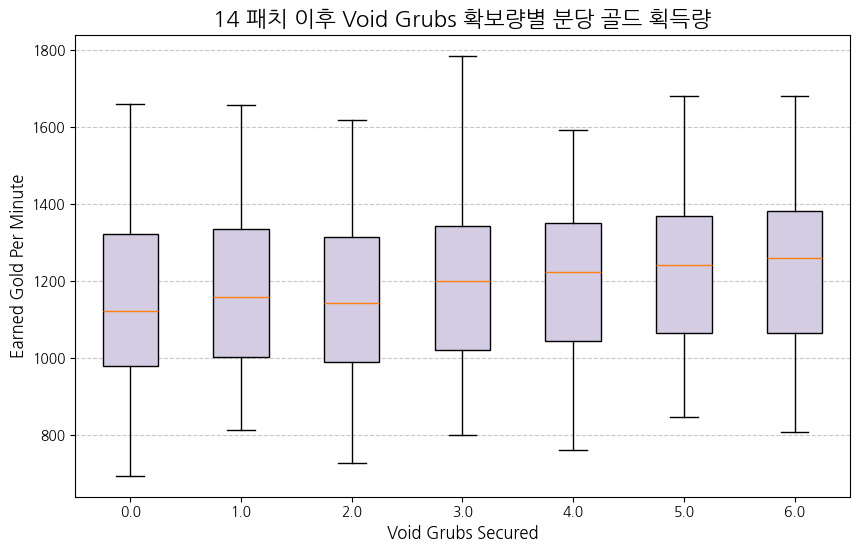

In [ ]:
if {'void_grubs', 'earned gpm', 'patch'}.issubset(combined_data.columns):
    # 14 패치 이후 데이터 필터링
    patch_14_data = combined_data[combined_data['patch'] >= 14]

    # Void Grubs 값을 오름차순 정렬
    patch_14_data['void_grubs'] = patch_14_data['void_grubs'].astype(float)
    sorted_void_grubs = sorted(patch_14_data['void_grubs'].unique())

    # Boxplot 데이터를 준비
    data = [
        patch_14_data.loc[patch_14_data['void_grubs'] == vg, 'earned gpm']
        for vg in sorted_void_grubs
    ]

    # 시각화
    plt.figure(figsize=(10, 6))
    plt.boxplot(data, labels=sorted_void_grubs, patch_artist=True, boxprops=dict(facecolor="#D3CCE3"))
    plt.title('14 패치 이후 Void Grubs 확보량별 분당 골드 획득량', fontsize=16)
    plt.xlabel('Void Grubs Secured', fontsize=12)
    plt.ylabel('Earned Gold Per Minute', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
else:
    print("데이터에 'void_grubs', 'earned gpm', 'patch' 열이 필요합니다.")



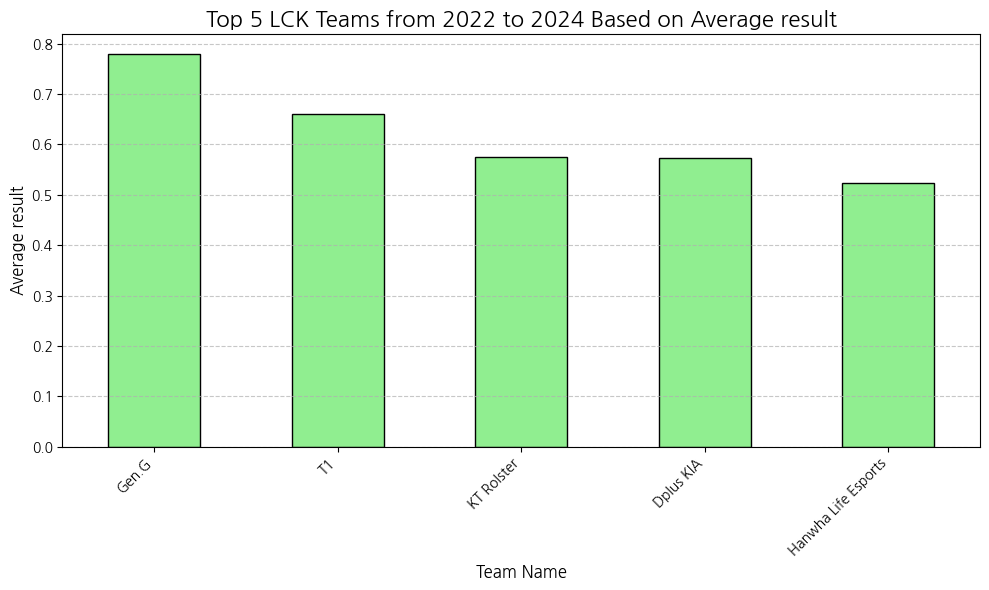

In [ ]:
# 2022-2024년 LCK 팀 데이터 필터링 및 상위권 팀 시각화
def visualize_top_lck_teams(data, start_year=2022, end_year=2024, league='LCK', result_column='result', team_column='teamname', top_n=5):
    if {'year', 'league', result_column, team_column}.issubset(data.columns):
        # 2022-2024년 LCK 데이터 필터링
        lck_data = data[(data['year'] >= start_year) & (data['year'] <= end_year) & (data['league'] == league)]

        # 팀별 평균 result 값 계산
        team_results = lck_data.groupby(team_column)[result_column].mean().sort_values(ascending=False)

        # 상위권 팀 선택
        top_teams = team_results.head(top_n)

        # 시각화
        plt.figure(figsize=(10, 6))
        top_teams.plot(kind='bar', color='lightgreen', edgecolor='black')
        plt.title(f'Top {top_n} LCK Teams from {start_year} to {end_year} Based on Average {result_column}', fontsize=16)
        plt.xlabel('Team Name', fontsize=12)
        plt.ylabel(f'Average {result_column}', fontsize=12)
        plt.xticks(rotation=45, ha='right')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()
    else:
        print(f"데이터에 'year', 'league', '{result_column}', '{team_column}' 열이 필요합니다.")

# 예시 실행
visualize_top_lck_teams(combined_data)

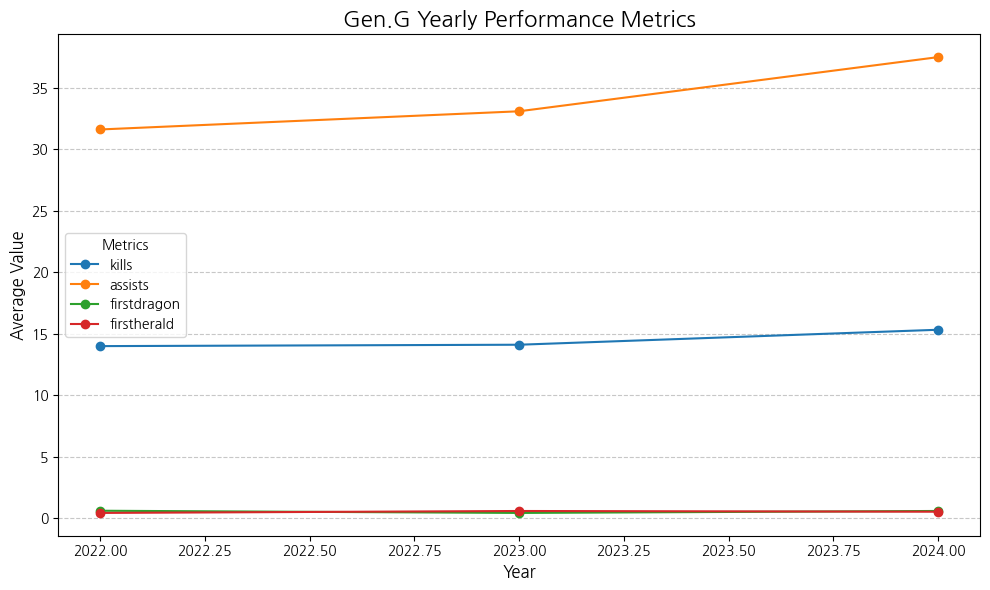

In [ ]:
# # 주요 지표를 연도별로 시각화

# def visualize_gen_g_yearly_stats(data, team_name='Gen.G'):
#     # Filter data for the specific team
#     team_data = data[data['teamname'] == team_name]

#     if {'year', 'kills', 'assists', 'firstdragon', 'firstherald'}.issubset(team_data.columns):
#         # Group by year and calculate mean values for selected metrics
#         metrics = ['kills', 'assists', 'firstdragon', 'firstherald']
#         yearly_stats = team_data.groupby('year')[metrics].mean()

#         # Plot each metric across years
#         plt.figure(figsize=(10, 6))
#         for metric in metrics:
#             plt.plot(yearly_stats.index, yearly_stats[metric], marker='o', label=metric)

#         plt.title(f'{team_name} Yearly Performance Metrics', fontsize=16)
#         plt.xlabel('Year', fontsize=12)
#         plt.ylabel('Average Value', fontsize=12)
#         plt.legend(title='Metrics', fontsize=10)
#         plt.grid(axis='y', linestyle='--', alpha=0.7)
#         plt.tight_layout()
#         plt.show()
#     else:
#         print("Required columns are missing in the dataset.")

# # Example usage
# visualize_gen_g_yearly_stats(combined_data)


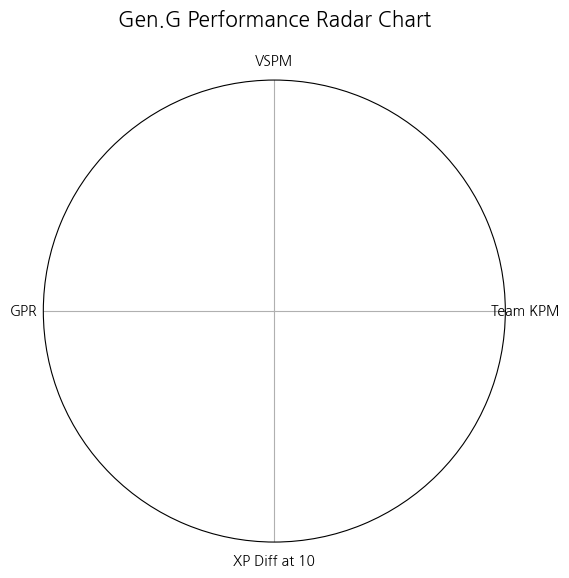

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np

# # 1. 데이터 준비
# categories = ['Team KPM', 'VSPM', 'GPR', 'XP Diff at 10']
# values = gen_g_data[['team kpm', 'vspm', 'gpr', 'xpdiffat10']].mean().tolist()  # Gen.G의 각 지표 평균값

# # 레이다 차트를 위한 데이터 처리
# num_vars = len(categories)
# angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
# values += values[:1]  # 시작점으로 되돌아가기 위해 첫 값을 마지막에 추가
# angles += angles[:1]

# # 2. 레이다 차트 그리기
# fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

# # 레이다 차트 다각형 및 외곽선 그리기
# ax.fill(angles, values, color='blue', alpha=0.25)
# ax.plot(angles, values, color='blue', linewidth=2)
# ax.set_yticks([])  # 내부 눈금 숨기기

# # 각 축 레이블 추가
# ax.set_xticks(angles[:-1])
# ax.set_xticklabels(categories, fontsize=10)

# # 제목 및 스타일 추가
# plt.title('Gen.G Performance Radar Chart', size=15, y=1.1)
# plt.show()


In [13]:
# Gen.G의 레이다 차트를 생성하는 함수
def create_gen_g_radar_chart(data, team_name='Gen.G'):
    # Gen.G 데이터 필터링
    gen_g_data = data[data['teamname'] == team_name]

    # 필요한 지표
    categories = ['Team KPM', 'VSPM', 'GPR', 'XP Diff at 10']
    metrics = ['team kpm', 'vspm', 'gpr', 'xpdiffat10']

    # 데이터 존재 여부 확인
    if not all(metric in gen_g_data.columns for metric in metrics):
        print(f"One or more metrics are missing: {metrics}")
        return


    # # 지표 평균값 계산
    # values = gen_g_data[metrics].mean().tolist()

    # # 레이다 차트를 위한 데이터 처리
    # num_vars = len(categories)
    # angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    # values += values[:1]  # 시작점으로 되돌아가기 위해 첫 값을 마지막에 추가
    # angles += angles[:1]

    # # 레이다 차트 그리기
    # fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

    # # 레이다 차트 다각형 및 외곽선 그리기
    # ax.fill(angles, values, color='blue', alpha=0.25)
    # ax.plot(angles, values, color='blue', linewidth=2)
    # ax.set_xticks(angles[:-1])
    # ax.set_xticklabels(categories, fontsize=10)

    # # 제목 및 스타일 추가
    # plt.title(f'{team_name} Performance Radar Chart', size=15, y=1.1)
    # plt.show()


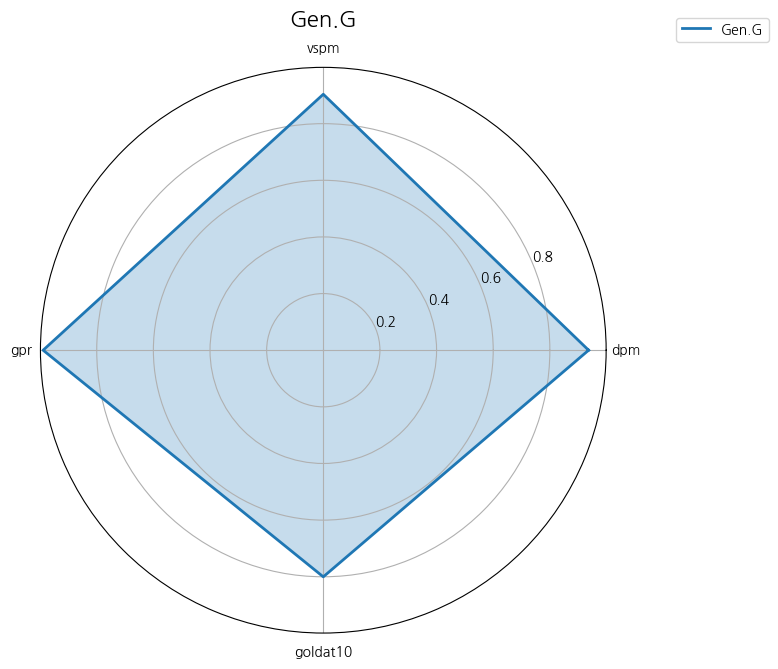

In [31]:
# Gen.G 팀 데이터를 필터링
gen_g_data = train_data[train_data['teamname'] == 'Gen.G']

# Gen.G 팀의 선택된 지표 평균 계산
metrics = ['dpm', 'vspm', 'gpr', 'goldat10']  # team kpm을 dpm으로 변경
gen_g_metrics = gen_g_data[metrics].mean()

# 'dpm' 값을 2500으로 나누어 스케일링
gen_g_metrics['dpm'] = gen_g_metrics['dpm'] / 2500

# 'goldat10' 값을 20000으로 나누어 스케일링
gen_g_metrics['goldat10'] = gen_g_metrics['goldat10'] / 20000

# 'vspm' 값을 조정 (10으로 나누어 스케일링)
gen_g_metrics['vspm'] = gen_g_metrics['vspm'] / 10

# 조정된 지표 값으로 값 재계산
values = gen_g_metrics.tolist()
values += [values[0]]  # 레이더 차트를 닫기 위해 첫 번째 값을 다시 추가

# 레이더 차트 설정
angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
angles += [angles[0]]  # 첫 번째 각도를 다시 추가하여 닫기

# 레이더 차트 생성
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
ax.plot(angles, values, linewidth=2, linestyle='solid', label='Gen.G')
ax.fill(angles, values, alpha=0.25)

# 레이블 및 눈금 추가
ax.set_xticks(angles[:-1])  # 닫는 각도는 레이블에서 제외
ax.set_xticklabels(metrics)

# 제목 및 범례 추가
ax.set_title("Gen.G", size=16,pad=30)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

# 레이더 차트 표시
plt.tight_layout()
plt.show()

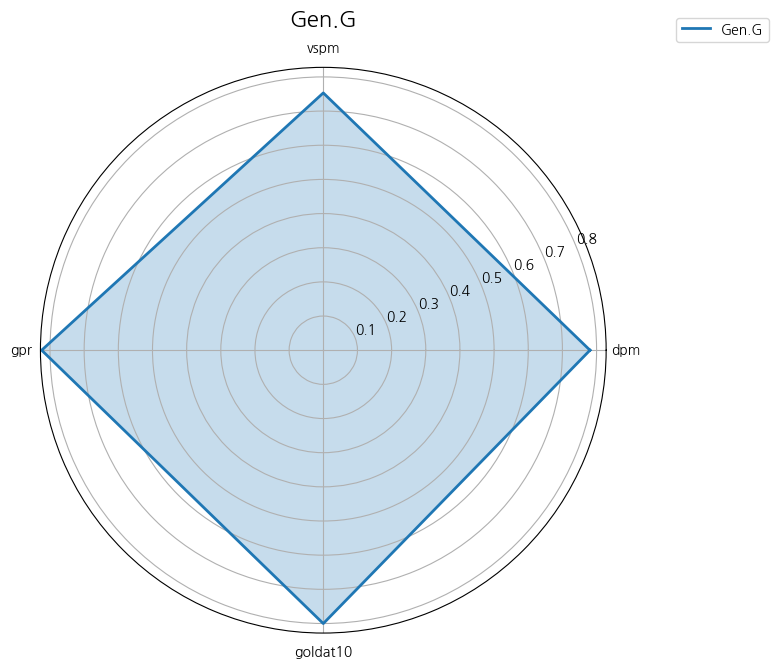

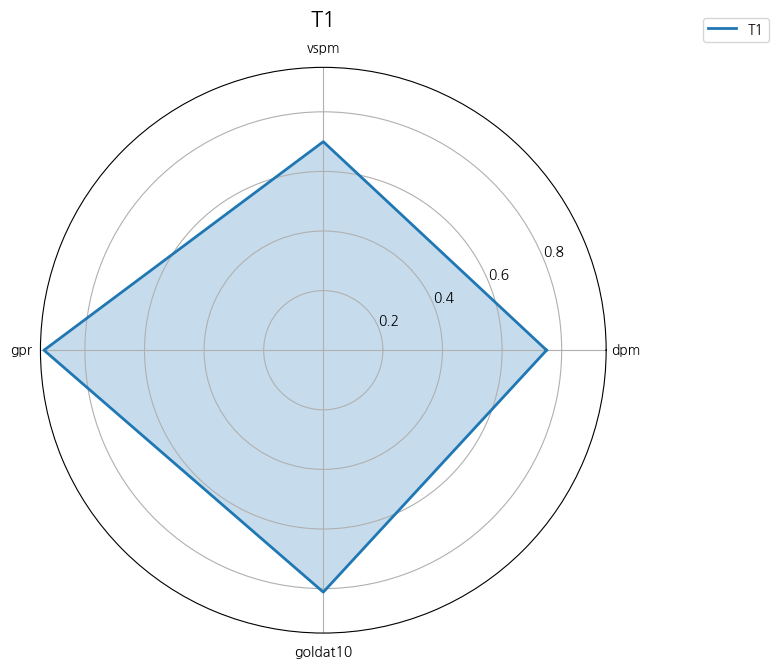

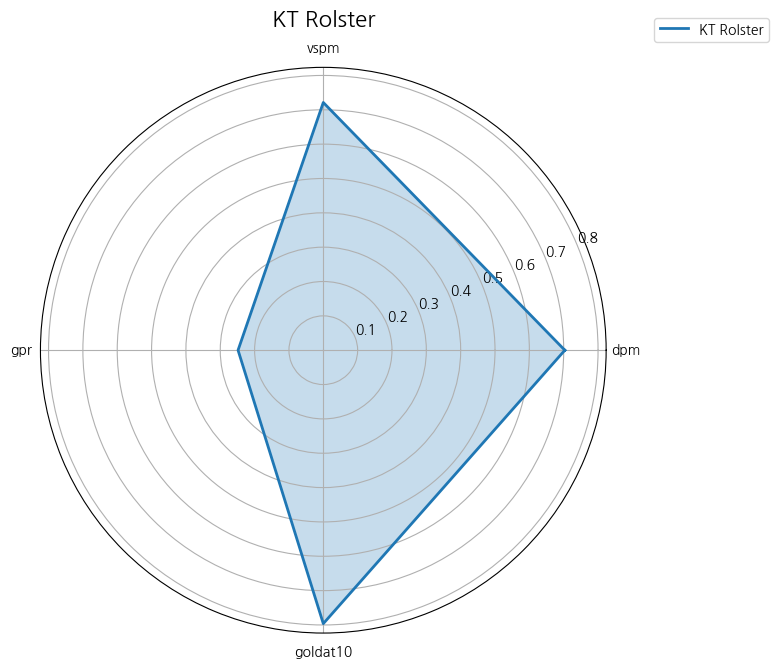

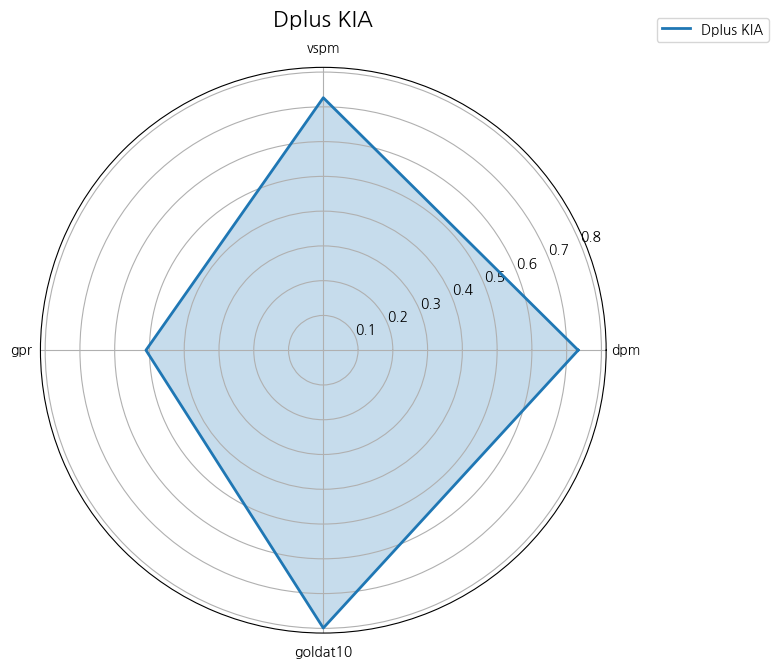

In [45]:
# 특정 팀의 데이터를 필터링하고 레이더 차트를 생성하는 함수
def create_radar_chart(teamname, data, metrics, scale_factors, title):
    team_data = data[data['teamname'] == teamname]
    team_metrics = team_data[metrics].mean()

    # 각 지표를 스케일링
    for metric, scale in scale_factors.items():
        team_metrics[metric] = team_metrics[metric] / scale

    # 값 계산 및 닫기
    values = team_metrics.tolist()
    values += [values[0]]
    angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
    angles += [angles[0]]

    # 레이더 차트 생성
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
    ax.plot(angles, values, linewidth=2, linestyle='solid', label=teamname)
    ax.fill(angles, values, alpha=0.25)

    # 레이블 및 눈금 추가
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(metrics)

    # 제목 및 범례 추가
    ax.set_title(title, size=16, pad=30)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

    # 차트 표시
    plt.tight_layout()
    plt.show()

# 설정된 팀과 지표
teams = ['Gen.G','T1', 'KT Rolster', 'Dplus KIA']
metrics = ['dpm', 'vspm', 'gpr', 'goldat10']
scale_factors = {'dpm': 3000, 'vspm': 12, 'goldat10': 20000, 'gpr':1.2,}  # dpm, vspm, goldat10 스케일링 설정

# 각 팀의 레이더 차트 생성
for team in teams:
    create_radar_chart(
        teamname=team,
        data=train_data,
        metrics=metrics,
        scale_factors=scale_factors,
        title=f"{team}"
    )
